# WGAN-GP + Adaptive-D Hooks (BCICIV-2b GDF)
This notebook is a **research-ready template**:
- Loads **BCI Competition IV 2b** `.gdf` files from `BCICIV_2b_gdf.zip`
- Standard **WGAN-GP** training (critic + gradient penalty)
- **Adaptive Discriminator hooks** (empty) for experimentation
- **History logging**, **checkpoint saving**, **best checkpoint saving**, and **resume support**
- **Training curve plots**


In [ ]:
# Run this once (for google colab)
# !mkdir -p data/BCICIV_2b_gdf
# !mv *.gdf data/BCICIV_2b_gdf/

In [6]:
# Cell 1 — Install deps (Colab-friendly)
# If you already installed these, you can skip this cell. 
%pip -q install mne numpy scipy


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Cell 2 — Imports & Reproducibility
import os
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Device:", DEVICE)

# Optional: reduce common numba-related surprises with some MNE setups
os.environ["NUMBA_DISABLE_JIT"] = "1"


Device: cuda


In [2]:
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

gdf_files = list(DATA_DIR.glob("*.gdf"))
print("Number of .gdf files:", len(gdf_files))

Number of .gdf files: 45


In [3]:
# Cell 3 — Dataset path check (NO unzip)
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

if not DATA_DIR.exists():
    raise FileNotFoundError(
        "DATA_DIR not found. Upload the extracted 'BCICIV_2b_gdf/' folder to ./data/"
    )

print("Using dataset directory:", DATA_DIR.resolve())
print("Found GDF files:", len(list(DATA_DIR.rglob("*.gdf"))))

Using dataset directory: /home/glider/gans_eeg/BCICIV_2b_gdf
Found GDF files: 45


In [4]:
# Cell 4 — Load BCICIV-2b (GDF -> epochs -> tensors) [FIXED: use annotation labels]
import mne
import numpy as np
from pathlib import Path
from typing import Dict, Optional, Tuple

def _find_gdf_files(root: Path) -> list:
    return sorted([p for p in root.rglob("*.gdf")])

def load_bciciv2b_epochs_by_labels(
    root: Path,
    file_glob: str = "*T.gdf",
    tmin: float = 0.0,
    tmax: float = 4.0,
    resample_hz: int = 256,
    picks: str = "eeg",
    baseline: Optional[Tuple[float, float]] = None,
    wanted_labels: Tuple[str, str] = ("769", "770"),  # left/right in BCICIV
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, int, Dict[str, int]]:
    all_files = _find_gdf_files(root)
    if file_glob:
        import fnmatch
        all_files = [f for f in all_files if fnmatch.fnmatch(f.name, file_glob)]

    if len(all_files) == 0:
        raise FileNotFoundError(f"No .gdf files found under {root} (file_glob={file_glob})")

    X_list, y_list = [], []
    last_sfreq = None

    # Fixed class order: wanted_labels[0] -> class 0, wanted_labels[1] -> class 1
    global_event_ids = {"left": wanted_labels[0], "right": wanted_labels[1]}

    for gdf_path in all_files:
        print("\n=== Reading:", gdf_path.name, "===")

        raw = mne.io.read_raw_gdf(str(gdf_path), preload=True, verbose="ERROR")
        raw.pick(picks)
        raw.resample(resample_hz)

        events, event_dict = mne.events_from_annotations(raw, verbose="ERROR")
        if verbose:
            print("Available annotation events:", event_dict)

        # Convert wanted annotation labels -> internal event codes for THIS file
        missing = [lab for lab in wanted_labels if lab not in event_dict]
        if len(missing) > 0:
            print(f"Skipping {gdf_path.name} (missing labels {missing})")
            continue

        event_id = {"left": event_dict[wanted_labels[0]], "right": event_dict[wanted_labels[1]]}
        print("Using internal event codes:", event_id, "(for labels", wanted_labels, ")")

        epochs = mne.Epochs(
            raw,
            events=events,
            event_id=event_id,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            preload=True,
            reject=None,
            on_missing="warn",
            verbose="ERROR",
        )

        if len(epochs) == 0:
            print(f"No epochs created for {gdf_path.name}. Skipping.")
            continue

        data = epochs.get_data().astype(np.float32)  # (N, C, L)
        labels = epochs.events[:, -1]  # internal codes (e.g., 4/5)

        # Map internal codes to 0/1 consistently using event_id dict
        code_to_idx = {int(event_id["left"]): 0, int(event_id["right"]): 1}
        y = np.array([code_to_idx[int(c)] for c in labels], dtype=np.int64)

        X_list.append(data)
        y_list.append(y)
        last_sfreq = int(raw.info["sfreq"])

    if len(X_list) == 0:
        raise RuntimeError(
            "No epochs were created from any file. "
            "Double-check dataset contents and wanted_labels."
        )

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y, last_sfreq, global_event_ids

# ---- Configure epoching ----
RESAMPLE_HZ = 256
TMIN, TMAX = 0.0, 4.0
FILE_GLOB = "*T.gdf"  # good default for training runs

X_np, y_np, sfreq, USED_LABELS = load_bciciv2b_epochs_by_labels(
    root=DATA_DIR,
    file_glob=FILE_GLOB,
    tmin=TMIN,
    tmax=TMAX,
    resample_hz=RESAMPLE_HZ,
    picks="eeg",
    baseline=None,
    wanted_labels=("769", "770"),
    verbose=True,
)

# Fix SEQ_LEN to be divisible by 16 (crop the last sample if needed)
SEQ_LEN = X_np.shape[2]
if SEQ_LEN % 16 != 0:
    new_len = (SEQ_LEN // 16) * 16  # floor to nearest multiple of 16
    print(f"Cropping SEQ_LEN from {SEQ_LEN} -> {new_len} to satisfy architecture constraint.")
    X_np = X_np[:, :, :new_len]

CHANNELS = X_np.shape[1]
SEQ_LEN  = X_np.shape[2]
print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN)
assert SEQ_LEN % 16 == 0

# print("\nLoaded X:", X_np.shape, "y:", y_np.shape, "sfreq:", sfreq)
# CHANNELS = X_np.shape[1]
# SEQ_LEN  = X_np.shape[2]
# print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN, "(must be divisible by 16)")


=== Reading: B0101T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0102T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('32766'): 2, np.str_('768'): 3, np.str_('769'): 4, np.str_('770'): 5}
Using internal event codes: {'left': 4, 'right': 5} (for labels ('769', '770') )

=== Reading: B0103T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11, np.str_('781'): 12}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0201T.g

In [5]:
# Cell 5 — Torch Dataset + Normalization
class EEGTensorDataset(Dataset):
    def __init__(self, X: np.ndarray, y: Optional[np.ndarray] = None, zscore_per_channel: bool = True):
        """
        X: (N, C, L)
        y: optional (N,)
        zscore_per_channel:
          - global per-channel mean/std computed across (N,L) for each channel
        """
        assert X.ndim == 3
        self.X = X.astype(np.float32)
        self.y = None if y is None else y.astype(np.int64)

        if zscore_per_channel:
            mean = self.X.mean(axis=(0, 2), keepdims=True)
            std  = self.X.std(axis=(0, 2), keepdims=True) + 1e-6
            self.X = (self.X - mean) / std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])  # (C, L)
        if self.y is None:
            return x
        return x, int(self.y[idx])

# Unconditional GAN: we only use x; y is available if you want conditional later
dataset = EEGTensorDataset(X_np, y=None, zscore_per_channel=True)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0, pin_memory=(DEVICE=="cuda"))
print("Batches:", len(loader))


Batches: 57


In [6]:
# Cell 6 — Models (Generator / Critic) + Init
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class Generator1D(nn.Module):
    def __init__(self, z_dim: int, out_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.init_len = seq_len // 16
        self.fc = nn.Linear(z_dim, base * 8 * self.init_len)
        self.net = nn.Sequential(
            nn.ConvTranspose1d(base * 8, base * 4, 4, 2, 1),
            nn.BatchNorm1d(base * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 4, base * 2, 4, 2, 1),
            nn.BatchNorm1d(base * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 2, base, 4, 2, 1),
            nn.BatchNorm1d(base),
            nn.ReLU(True),

            nn.ConvTranspose1d(base, out_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), -1, self.init_len)
        return self.net(x)

class Critic1D(nn.Module):
    def __init__(self, in_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, base, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base, base * 2, 4, 2, 1),
            nn.InstanceNorm1d(base * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 2, base * 4, 4, 2, 1),
            nn.InstanceNorm1d(base * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 4, base * 8, 4, 2, 1),
            nn.InstanceNorm1d(base * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Linear(base * 8 * (seq_len // 16), 1)

    def forward(self, x):
        h = self.net(x)
        h = h.view(x.size(0), -1)
        return self.out(h).view(-1)  # (B,)

Z_DIM = 128
G = Generator1D(Z_DIM, CHANNELS, SEQ_LEN).to(DEVICE)
D = Critic1D(CHANNELS, SEQ_LEN).to(DEVICE)
G.apply(weights_init)
D.apply(weights_init)

print("G params:", sum(p.numel() for p in G.parameters())/1e6, "M")
print("D params:", sum(p.numel() for p in D.parameters())/1e6, "M")


G params: 4.918086 M
D params: 0.725185 M


In [7]:
# Cell 7 — WGAN-GP utilities (gradient penalty) + sampling
def gradient_penalty(critic: nn.Module, real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
    bsz = real.size(0)
    eps = torch.rand(bsz, 1, 1, device=real.device)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)
    d_hat = critic(x_hat)

    grads = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grads = grads.view(bsz, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

@torch.no_grad()
def sample_generator(generator: nn.Module, n: int, z_dim: int) -> torch.Tensor:
    z = torch.randn(n, z_dim, device=DEVICE)
    return generator(z).cpu()


In [ ]:
# Cell 8 — Adaptive-D Controller (EMPTY hooks)
@dataclass
class TrainState:
    step: int = 0
    epoch: int = 0
    n_critic: int = 5
    lambda_gp: float = 10.0

    wasserstein_gap_ema: float = 0.0
    ema_beta: float = 0.99

    best_score: float = -1e18  # IMPORTANT: for best-checkpoint logic

class AdaptiveDiscriminatorController:
    def __init__(self):
        # Put your adaptive variables / EMA buffers / thresholds here
        pass

    def on_batch_start(self, state: TrainState) -> None:
        # TODO: optionally adjust state.n_critic / state.lambda_gp etc.
        pass

    def on_after_critic_update(self, state: TrainState, metrics: Dict[str, float], optim_D: torch.optim.Optimizer) -> None:
        # TODO: optionally adjust critic optimizer hyperparams, freeze layers, etc.
        pass

    def on_after_generator_update(self, state: TrainState, metrics: Dict[str, float], optim_G: torch.optim.Optimizer) -> None:
        # TODO: optionally adjust based on generator gradient norm (metrics["g_grad_norm"])
        pass

controller = AdaptiveDiscriminatorController()
                                                                                                            

In [9]:
# Cell 9 — Optimizers + checkpoint utils + history init
LR = 1e-4
BETAS = (0.0, 0.9)
optim_G = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optim_D = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

state = TrainState(step=0, epoch=0, n_critic=5, lambda_gp=10.0)

CKPT_DIR = Path("./checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

history = defaultdict(list)

def save_checkpoint(path: str, G, D, optim_G, optim_D, state: TrainState, history: dict):
    payload = {
        "G": G.state_dict(),
        "D": D.state_dict(),
        "optim_G": optim_G.state_dict(),
        "optim_D": optim_D.state_dict(),
        "state": state.__dict__,
        "history": dict(history),
    }
    torch.save(payload, path)

def load_checkpoint(path: str, G, D, optim_G=None, optim_D=None) -> Tuple[TrainState, dict]:
    ckpt = torch.load(path, map_location=DEVICE)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    if optim_G is not None and "optim_G" in ckpt:
        optim_G.load_state_dict(ckpt["optim_G"])
    if optim_D is not None and "optim_D" in ckpt:
        optim_D.load_state_dict(ckpt["optim_D"])
    state = TrainState(**ckpt["state"])
    hist = ckpt.get("history", {})
    return state, hist

print("LR:", LR, "BETAS:", BETAS, "n_critic:", state.n_critic, "lambda_gp:", state.lambda_gp)


LR: 0.0001 BETAS: (0.0, 0.9) n_critic: 5 lambda_gp: 10.0


In [12]:
# Cell 10 — Training Loop (Standard WGAN-GP + Adaptive Hooks + Saving)
def compute_grad_norm(parameters) -> float:
    total = 0.0
    for p in parameters:
        if p.grad is None:
            continue
        param_norm = p.grad.detach().data.norm(2).item()
        total += param_norm ** 2
    return float(total ** 0.5)

def train_wgan_gp(
    loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    optim_G: torch.optim.Optimizer,
    optim_D: torch.optim.Optimizer,
    state: TrainState,
    controller: AdaptiveDiscriminatorController,
    history: dict,
    z_dim: int,
    epochs: int = 10,
    log_every: int = 50,
    save_every_steps: int = 500,
    best_metric: str = "gap_ema",  # "gap_ema" (default) or "gap" etc.
):
    G.train(); D.train()

    for epoch in range(epochs):
        state.epoch = epoch

        for batch_idx, real in enumerate(loader):
            state.step += 1
            controller.on_batch_start(state)

            real = real.to(DEVICE)
            bsz = real.size(0)

            # -------------------------
            # Critic updates (n_critic)
            # -------------------------
            metrics_D = None
            for _ in range(state.n_critic):
                z = torch.randn(bsz, z_dim, device=DEVICE)
                fake = G(z).detach()

                d_real = D(real).mean()
                d_fake = D(fake).mean()
                gap = (d_real - d_fake).item()

                gp = gradient_penalty(D, real, fake)
                loss_D = (d_fake - d_real) + state.lambda_gp * gp

                optim_D.zero_grad(set_to_none=True)
                loss_D.backward()
                optim_D.step()

                # EMA of the gap (useful for adaptive control)
                state.wasserstein_gap_ema = state.ema_beta * state.wasserstein_gap_ema + (1 - state.ema_beta) * gap

                metrics_D = {
                    "d_real": float(d_real.item()),
                    "d_fake": float(d_fake.item()),
                    "gap": float(gap),
                    "gap_ema": float(state.wasserstein_gap_ema),
                    "gp": float(gp.item()),
                    "loss_D": float(loss_D.item()),
                }
                controller.on_after_critic_update(state, metrics_D, optim_D)

            # -------------------------
            # Generator update
            # -------------------------
            z = torch.randn(bsz, z_dim, device=DEVICE)
            fake = G(z)
            loss_G = -D(fake).mean()

            optim_G.zero_grad(set_to_none=True)
            loss_G.backward()

            # Compute Generator grad norm (optional adaptive signal)
            g_grad_norm = compute_grad_norm(G.parameters())

            optim_G.step()

            metrics_G = {"loss_G": float(loss_G.item()), "g_grad_norm": float(g_grad_norm)}
            controller.on_after_generator_update(state, metrics_G, optim_G)

            # -------------------------
            # Log + store history
            # -------------------------
            if metrics_D is not None:
                history["step"].append(int(state.step))
                history["epoch"].append(int(state.epoch))
                history["loss_D"].append(float(metrics_D["loss_D"]))
                history["loss_G"].append(float(metrics_G["loss_G"]))
                history["d_real"].append(float(metrics_D["d_real"]))
                history["d_fake"].append(float(metrics_D["d_fake"]))
                history["gap"].append(float(metrics_D["gap"]))
                history["gap_ema"].append(float(metrics_D["gap_ema"]))
                history["gp"].append(float(metrics_D["gp"]))
                history["g_grad_norm"].append(float(metrics_G["g_grad_norm"]))
                history["n_critic"].append(int(state.n_critic))
                history["lambda_gp"].append(float(state.lambda_gp))

            if (batch_idx % log_every) == 0 and metrics_D is not None:
                print(
                    f"[Epoch {epoch:03d}/{epochs:03d}] [Batch {batch_idx:04d}/{len(loader):04d}] "
                    f"[n_critic: {state.n_critic}] "
                    f"[gap: {metrics_D['gap']:+.3f} | ema: {metrics_D['gap_ema']:+.3f}] "
                    f"[GP: {metrics_D['gp']:.3f}] "
                    f"[g|grad|: {metrics_G['g_grad_norm']:.3f}] "
                    f"[D: {metrics_D['loss_D']:+.3f}] [G: {metrics_G['loss_G']:+.3f}]"
                )

            # -------------------------
            # Save periodic checkpoint
            # -------------------------
            if save_every_steps > 0 and (state.step % save_every_steps) == 0:
                ckpt_path = CKPT_DIR / f"ckpt_step_{state.step}.pt"
                save_checkpoint(str(ckpt_path), G, D, optim_G, optim_D, state, history)
                print("Saved:", ckpt_path)

            # -------------------------
            # Save "best" checkpoint
            # -------------------------
            if metrics_D is not None:
                score = float(metrics_D.get(best_metric, -1e18))
                if score > float(state.best_score):
                    state.best_score = float(score)
                    best_path = CKPT_DIR / "best.pt"
                    save_checkpoint(str(best_path), G, D, optim_G, optim_D, state, history)
                    print(f"New BEST ({best_metric}={score:.4f}) -> saved to {best_path}")

    return state, history

# ---- Run training ----
state, history = train_wgan_gp(
    loader=loader,
    G=G,
    D=D,
    optim_G=optim_G,
    optim_D=optim_D,
    state=state,
    controller=controller,
    history=history,
    z_dim=Z_DIM,
    epochs=10,
    log_every=50,
    save_every_steps=500,
    best_metric="gap_ema",
)

# Optional — Save final generator/critic weights (inference-only)
torch.save(G.state_dict(), "generator_final.pt")
torch.save(D.state_dict(), "critic_final.pt")
print("Saved inference-only weights: generator_final.pt, critic_final.pt")


[Epoch 000/010] [Batch 0000/0057] [n_critic: 5] [gap: +64.202 | ema: +41.363] [GP: 1.724] [g|grad|: 31.307] [D: -46.961] [G: +97.406]
New BEST (gap_ema=41.3628) -> saved to checkpoints/best.pt
New BEST (gap_ema=42.3772) -> saved to checkpoints/best.pt
New BEST (gap_ema=43.5374) -> saved to checkpoints/best.pt
New BEST (gap_ema=44.3414) -> saved to checkpoints/best.pt
New BEST (gap_ema=44.9683) -> saved to checkpoints/best.pt
New BEST (gap_ema=45.8346) -> saved to checkpoints/best.pt
New BEST (gap_ema=46.7277) -> saved to checkpoints/best.pt
New BEST (gap_ema=47.5868) -> saved to checkpoints/best.pt
New BEST (gap_ema=48.5393) -> saved to checkpoints/best.pt
New BEST (gap_ema=49.4481) -> saved to checkpoints/best.pt
New BEST (gap_ema=50.2812) -> saved to checkpoints/best.pt
New BEST (gap_ema=51.3138) -> saved to checkpoints/best.pt
New BEST (gap_ema=52.0395) -> saved to checkpoints/best.pt
New BEST (gap_ema=52.8549) -> saved to checkpoints/best.pt
New BEST (gap_ema=53.5031) -> saved to c

In [13]:
# Cell 11 — Resume from a checkpoint (example)
# Uncomment to resume:
# ckpt_path = "./checkpoints/best.pt"   # or "./checkpoints/ckpt_step_500.pt"
# state, loaded_hist = load_checkpoint(ckpt_path, G, D, optim_G, optim_D)
# # If you want to continue appending history:
# history = defaultdict(list, loaded_hist)
# print("Resumed at step:", state.step, "epoch:", state.epoch, "best_score:", state.best_score)


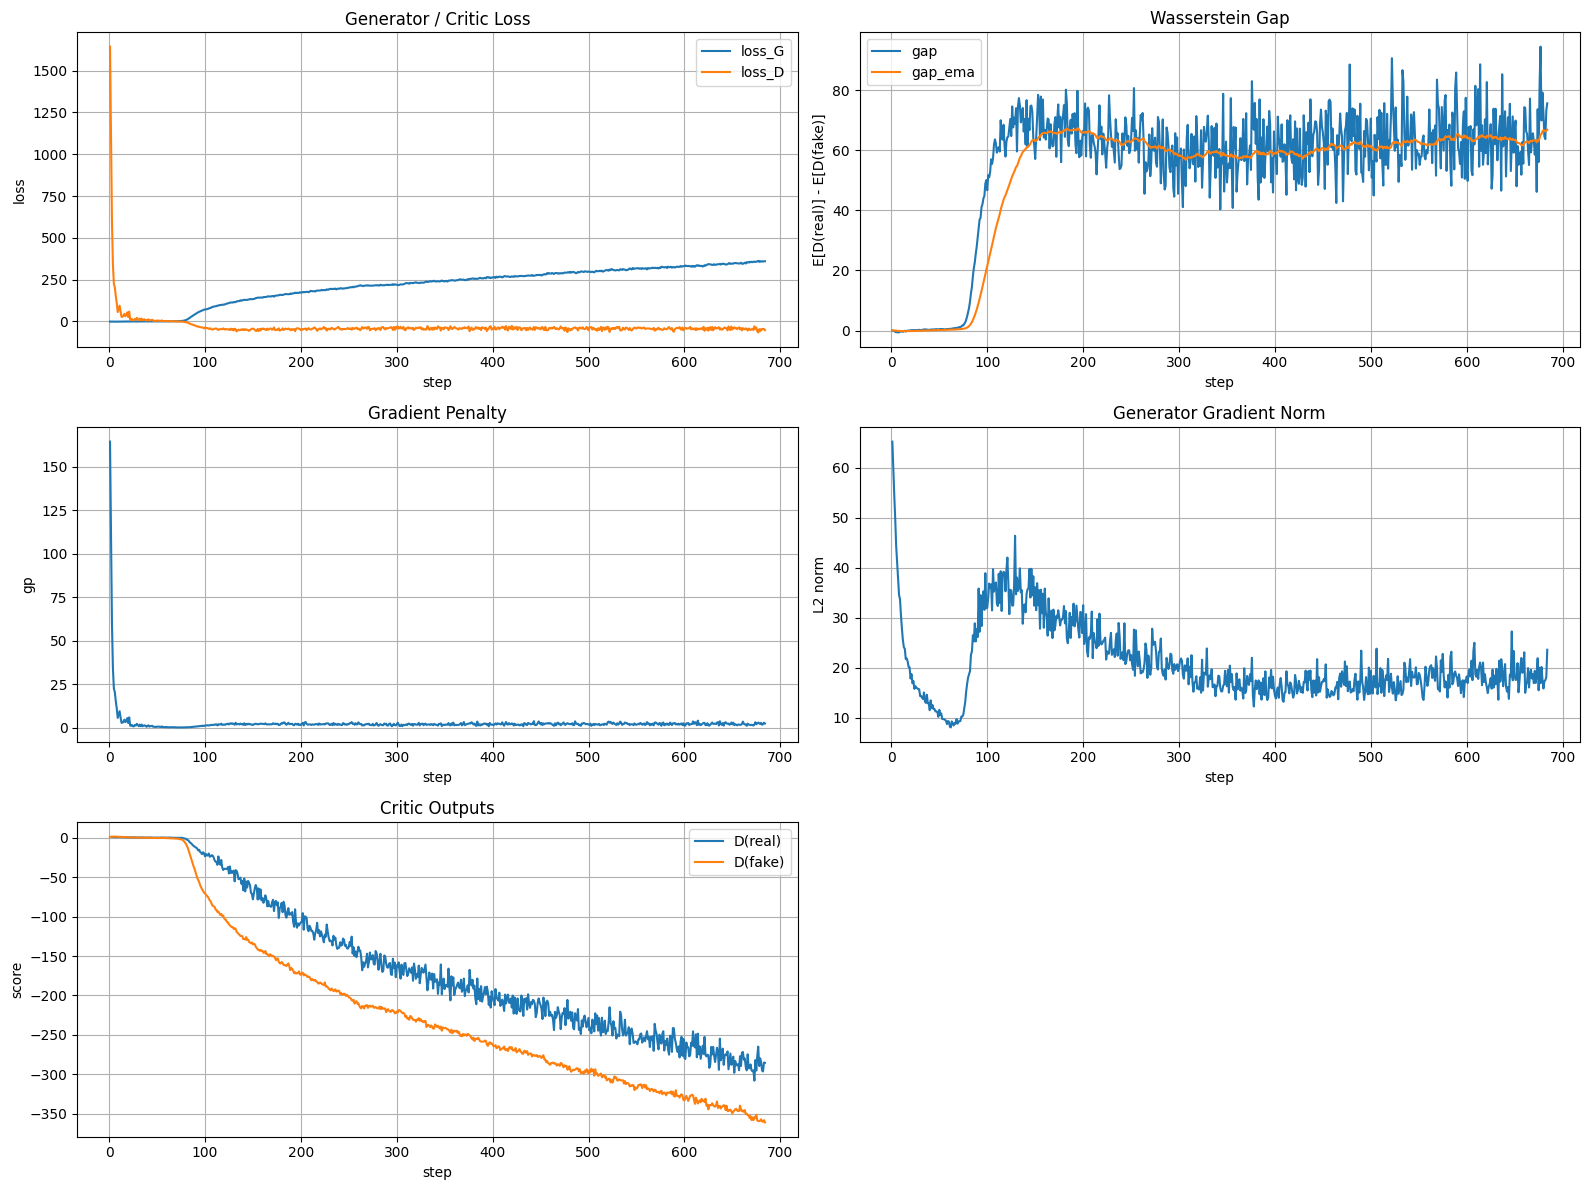

In [14]:
# Cell 12 — Training Curve Visualization
import matplotlib.pyplot as plt

def _safe_get(history: dict, key: str):
    v = history.get(key, None)
    if v is None:
        return None
    return list(v)

def plot_history(history: dict):
    keys = list(history.keys())
    if len(keys) == 0:
        print("History is empty. Train first.")
        return

    step = _safe_get(history, "step")
    if step is None:
        # fallback to index
        step = list(range(len(next(iter(history.values())))))

    plt.figure(figsize=(16, 12))

    # Losses
    plt.subplot(3, 2, 1)
    if "loss_G" in history: plt.plot(step, history["loss_G"], label="loss_G")
    if "loss_D" in history: plt.plot(step, history["loss_D"], label="loss_D")
    plt.title("Generator / Critic Loss")
    plt.xlabel("step"); plt.ylabel("loss")
    plt.legend(); plt.grid(True)

    # Wasserstein gap
    plt.subplot(3, 2, 2)
    if "gap" in history: plt.plot(step, history["gap"], label="gap")
    if "gap_ema" in history: plt.plot(step, history["gap_ema"], label="gap_ema")
    plt.title("Wasserstein Gap")
    plt.xlabel("step"); plt.ylabel("E[D(real)] - E[D(fake)]")
    plt.legend(); plt.grid(True)

    # Gradient penalty
    plt.subplot(3, 2, 3)
    if "gp" in history: plt.plot(step, history["gp"], label="gp")
    plt.title("Gradient Penalty")
    plt.xlabel("step"); plt.ylabel("gp")
    plt.grid(True)

    # Generator gradient norm
    plt.subplot(3, 2, 4)
    if "g_grad_norm" in history: plt.plot(step, history["g_grad_norm"], label="||∇G||")
    plt.title("Generator Gradient Norm")
    plt.xlabel("step"); plt.ylabel("L2 norm")
    plt.grid(True)

    # Critic outputs (optional)
    plt.subplot(3, 2, 5)
    if "d_real" in history: plt.plot(step, history["d_real"], label="D(real)")
    if "d_fake" in history: plt.plot(step, history["d_fake"], label="D(fake)")
    plt.title("Critic Outputs")
    plt.xlabel("step"); plt.ylabel("score")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)
